In [5]:
from datetime import datetime
import pandas as pd
from geopy.distance import distance
import numpy as np
import random
import json

import pymongo
from pymongo import MongoClient



from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



import pymongo
from pymongo import MongoClient

import matplotlib.pyplot as plt

plt.style.use("ggplot")

%matplotlib inline

In [6]:
# Load in our parameters file
with open('../parameters.json') as f:
    params = json.load(f)

# Get relevant parameters
database = params['database']
labeled_collection = params['labeled_collection']
chunk_collection = params['chunk_collection']
# duration_collection = params['duration_collection']
# two_chunk_collection = params['two_chunk_collection']
# six_chunk_collection = params['six_chunk_collection']

# Connect to our database/collection
client = MongoClient('localhost', 27017)
db = client[database]
trip_coll = db[labeled_collection]
chunk_coll = db[chunk_collection]
# duration_coll = db[duration_collection]
# two_chunk_coll = db[two_chunk_collection]
# six_chunk_coll = db[six_chunk_collection]

In [7]:
client = MongoClient('localhost', 27017)

db = client[database]

trip_coll = db[labeled_collection]
chnk_coll = db[chunk_collection]

In [8]:
trip_coll.find_one()

{'_id': ObjectId('5af0b6e53ad39ec039a1ba4b'),
 'HEADING': '75.0',
 'LATITUDE': '37.78701',
 'LONGITUDE': '-122.45647',
 'PREDICTABLE': '1',
 'REPORT_TIME': '10/08/2016 00:26:42',
 'REV': '1526',
 'SPEED': '0.0',
 'TRAIN_ASSIGNMENT': '3305',
 'VEHICLE_TAG': '5484',
 'minutes_noon_sqr': 481636,
 'sched_time_diff_seconds': 198,
 'service_id': 1,
 'time_stamp': 1475911602.0,
 'trip_id': 7253717,
 'trip_id_iso': '7253717_2016-10-08_4489K',
 'trip_start': 1,
 'chunk_2': '1',
 'chunk_6': '1'}

In [9]:
six_cnk_info = chnk_coll.find_one({'number_chunks':6})

In [12]:
all_trips = trip_coll.distinct('trip_id_iso')
# # Testing
# all_trips = all_trips[33:40]

In [13]:
trip_list = []

for idx, trip in enumerate(all_trips):

    print ("Getting Two-Chunk data for ", trip)
    print ("Number ", idx+1, " of ", len(all_trips))
    
    trip_data = {}
    
    breakin = 0

    search = {
                'trip_id_iso': trip_id,
                'trip_start': 1
            }
    
    trip_start = trip_coll.find_one(search)
    
    if not trip_start:
        continue

    for chnk_seq, chnk_data in six_cnk_info['chunks'].items():
        
        if chnk_seq in ['2','3']:
        
            search = {
                'trip_id_iso': trip_id,
                'chunk_6': chnk_seq
            }

            chnk_str = '_chnk_' + chnk_seq

            chnk_cursor = trip_coll.find(search)
            
            if chnk_cursor.count() == 0:
                breakin += 1
                break

            chnk_df = pd.DataFrame(list(chnk_cursor))

            min_ts = chnk_df['time_stamp'].min()
            max_ts = chnk_df['time_stamp'].max()
            chnk_secs = max_ts - min_ts
            
            if chnk_secs > 2500:
                breakin += 1
                break
    
  
            trip_data['seconds' + chnk_str ] = chnk_secs

            min_dt = datetime.fromtimestamp(min_ts)
            mfn_sq = (((min_dt.hour * 60) + min_dt.minute) - 720)**2

            mfn_abs = abs(((min_dt.hour * 60) + min_dt.minute) - 720)
        
            trip_data['mfn_sq' + chnk_str] = mfn_sq
            trip_data['mfn_abs' + chnk_str] = mfn_abs
            
            avg_spd = chnk_df['SPEED'].astype('float').mean()

            trip_data['avg_speed' + chnk_str] = avg_spd
     
    
    first_trip_ts = trip_start['time_stamp']
    
    before_search = {
        'time_stamp': {'$lt': first_trip_ts},
        'trip_start': 1
    }
    
    most_recent = list(trip_coll.find(before_search).sort('time_stamp', pymongo.DESCENDING).limit(1))
    
    if not most_recent:
        continue
        
    most_recent = most_recent[0]
    
    prior_ts = most_recent['time_stamp']
    prior_id = most_recent['trip_id_iso']
    
    start_diff = first_trip_ts - prior_ts
    
    if start_diff > 1800:
        continue
        
        
    # Get prior chunk data
    for chnk_seq, chnk_data in six_cnk_info['chunks'].items():

        if chnk_seq in ['2','3']:

            search = {
                'trip_id_iso': prior_id,
                'chunk_6': chnk_seq
            }

            chnk_str = '_prior_chnk_' + chnk_seq

            chnk_cursor = trip_coll.find(search)

            if chnk_cursor.count() == 0:
                breakin += 1
                break

            chnk_df = pd.DataFrame(list(chnk_cursor))

            min_ts = chnk_df['time_stamp'].min()
            max_ts = chnk_df['time_stamp'].max()
            chnk_secs = max_ts - min_ts

            if chnk_secs > 2500:
                breakin += 1
                break


            trip_data['seconds' + chnk_str ] = chnk_secs

            min_dt = datetime.fromtimestamp(min_ts)
            mfn_sq = (((min_dt.hour * 60) + min_dt.minute) - 720)**2

            mfn_abs = abs(((min_dt.hour * 60) + min_dt.minute) - 720)

            trip_data['mfn_sq' + chnk_str] = mfn_sq
            trip_data['mfn_abs' + chnk_str] = mfn_abs

            avg_spd = chnk_df['SPEED'].astype('float').mean()

            trip_data['avg_speed' + chnk_str] = avg_spd
        
    
    if breakin == 0:
    
        trip_list.append(trip_data)

Getting Two-Chunk data for  7253717_2016-10-08_4489K
Number  1  of  1910
Getting Two-Chunk data for  7253845_2016-10-08_GHNYG
Number  2  of  1910
Getting Two-Chunk data for  7253837_2016-10-08_8Q6DP
Number  3  of  1910
Getting Two-Chunk data for  7253830_2016-10-08_SR1KP
Number  4  of  1910
Getting Two-Chunk data for  7253823_2016-10-08_TDW9M
Number  5  of  1910
Getting Two-Chunk data for  7253960_2016-10-09_V32MR
Number  6  of  1910
Getting Two-Chunk data for  7253952_2016-10-09_W6GVE
Number  7  of  1910
Getting Two-Chunk data for  7253945_2016-10-09_HCAYV
Number  8  of  1910
Getting Two-Chunk data for  7253938_2016-10-09_8H6WY
Number  9  of  1910
Getting Two-Chunk data for  7253931_2016-10-09_I034P
Number  10  of  1910
Getting Two-Chunk data for  7253711_2016-10-11_MFFWI
Number  11  of  1910
Getting Two-Chunk data for  7253702_2016-10-11_71PTR
Number  12  of  1910
Getting Two-Chunk data for  7253693_2016-10-11_T8DFQ
Number  13  of  1910
Getting Two-Chunk data for  7253684_2016-10-11_

Getting Two-Chunk data for  7253659_2016-10-28_42VXE
Number  112  of  1910
Getting Two-Chunk data for  7253654_2016-10-28_J9WG8
Number  113  of  1910
Getting Two-Chunk data for  7253845_2016-10-29_W6U2Y
Number  114  of  1910
Getting Two-Chunk data for  7253837_2016-10-29_QXDXZ
Number  115  of  1910
Getting Two-Chunk data for  7253830_2016-10-29_S2A00
Number  116  of  1910
Getting Two-Chunk data for  7253816_2016-10-29_T5RBZ
Number  117  of  1910
Getting Two-Chunk data for  7253960_2016-10-30_4F7CJ
Number  118  of  1910
Getting Two-Chunk data for  7253945_2016-10-30_3NGBN
Number  119  of  1910
Getting Two-Chunk data for  7253931_2016-10-30_L7X1M
Number  120  of  1910
Getting Two-Chunk data for  7253711_2016-10-31_WH5HA
Number  121  of  1910
Getting Two-Chunk data for  7253702_2016-10-31_0HI7A
Number  122  of  1910
Getting Two-Chunk data for  7253693_2016-10-31_6GA81
Number  123  of  1910
Getting Two-Chunk data for  7253684_2016-10-31_LHES3
Number  124  of  1910
Getting Two-Chunk data fo

Getting Two-Chunk data for  7253931_2016-11-20_SFVWP
Number  222  of  1910
Getting Two-Chunk data for  7253702_2016-11-22_R5RZ9
Number  223  of  1910
Getting Two-Chunk data for  7253659_2016-11-22_GW7J4
Number  224  of  1910
Getting Two-Chunk data for  7253717_2016-11-23_PSXXS
Number  225  of  1910
Getting Two-Chunk data for  7253711_2016-11-23_ZUL5L
Number  226  of  1910
Getting Two-Chunk data for  7253693_2016-11-23_XJEPQ
Number  227  of  1910
Getting Two-Chunk data for  7253684_2016-11-23_CWJHN
Number  228  of  1910
Getting Two-Chunk data for  7253675_2016-11-23_HHKPJ
Number  229  of  1910
Getting Two-Chunk data for  7253666_2016-11-23_801CZ
Number  230  of  1910
Getting Two-Chunk data for  7253659_2016-11-23_JMEJU
Number  231  of  1910
Getting Two-Chunk data for  7253654_2016-11-23_3CK7P
Number  232  of  1910
Getting Two-Chunk data for  7253960_2016-12-04_3GK4E
Number  233  of  1910
Getting Two-Chunk data for  7253952_2016-12-04_021EJ
Number  234  of  1910
Getting Two-Chunk data fo

Getting Two-Chunk data for  7253838_2016-10-22_RSHVG
Number  332  of  1910
Getting Two-Chunk data for  7253824_2016-10-22_BGLPI
Number  333  of  1910
Getting Two-Chunk data for  7253817_2016-10-22_AY4QP
Number  334  of  1910
Getting Two-Chunk data for  7253714_2016-10-24_0C6ML
Number  335  of  1910
Getting Two-Chunk data for  7253706_2016-10-24_J4DXL
Number  336  of  1910
Getting Two-Chunk data for  7253697_2016-10-24_5D9AJ
Number  337  of  1910
Getting Two-Chunk data for  7253688_2016-10-24_D31VB
Number  338  of  1910
Getting Two-Chunk data for  7253679_2016-10-24_1TCL9
Number  339  of  1910
Getting Two-Chunk data for  7253670_2016-10-24_B8460
Number  340  of  1910
Getting Two-Chunk data for  7253662_2016-10-24_KHTS8
Number  341  of  1910
Getting Two-Chunk data for  7253652_2016-10-24_4HG5G
Number  342  of  1910
Getting Two-Chunk data for  7253706_2016-10-25_3NLM4
Number  343  of  1910
Getting Two-Chunk data for  7253688_2016-10-25_YNJK0
Number  344  of  1910
Getting Two-Chunk data fo

Getting Two-Chunk data for  7253706_2016-11-14_X8V7R
Number  442  of  1910
Getting Two-Chunk data for  7253697_2016-11-14_VHQBW
Number  443  of  1910
Getting Two-Chunk data for  7253688_2016-11-14_06216
Number  444  of  1910
Getting Two-Chunk data for  7253679_2016-11-14_NF7YN
Number  445  of  1910
Getting Two-Chunk data for  7253670_2016-11-14_3T342
Number  446  of  1910
Getting Two-Chunk data for  7253662_2016-11-14_PFPCT
Number  447  of  1910
Getting Two-Chunk data for  7253656_2016-11-14_XHY8C
Number  448  of  1910
Getting Two-Chunk data for  7253652_2016-11-14_9UJMO
Number  449  of  1910
Getting Two-Chunk data for  7253714_2016-11-15_ERRYB
Number  450  of  1910
Getting Two-Chunk data for  7253706_2016-11-15_34L93
Number  451  of  1910
Getting Two-Chunk data for  7253697_2016-11-15_7VMZO
Number  452  of  1910
Getting Two-Chunk data for  7253688_2016-11-15_PN1I9
Number  453  of  1910
Getting Two-Chunk data for  7253679_2016-11-15_1DF24
Number  454  of  1910
Getting Two-Chunk data fo

Getting Two-Chunk data for  7253951_2016-10-16_FEA2P
Number  552  of  1910
Getting Two-Chunk data for  7253944_2016-10-16_08ZXQ
Number  553  of  1910
Getting Two-Chunk data for  7253937_2016-10-16_12NAP
Number  554  of  1910
Getting Two-Chunk data for  7253930_2016-10-16_TWMOB
Number  555  of  1910
Getting Two-Chunk data for  7253715_2016-10-17_GEOCH
Number  556  of  1910
Getting Two-Chunk data for  7253708_2016-10-17_RBVUX
Number  557  of  1910
Getting Two-Chunk data for  7253699_2016-10-17_WZDQG
Number  558  of  1910
Getting Two-Chunk data for  7253681_2016-10-17_7IO5W
Number  559  of  1910
Getting Two-Chunk data for  7253663_2016-10-17_RP8XT
Number  560  of  1910
Getting Two-Chunk data for  7253657_2016-10-17_40FNQ
Number  561  of  1910
Getting Two-Chunk data for  7253653_2016-10-17_4TB6H
Number  562  of  1910
Getting Two-Chunk data for  7253715_2016-10-20_0TABL
Number  563  of  1910
Getting Two-Chunk data for  7253708_2016-10-20_MSRXI
Number  564  of  1910
Getting Two-Chunk data fo

Getting Two-Chunk data for  7253844_2016-11-12_AA10P
Number  662  of  1910
Getting Two-Chunk data for  7253836_2016-11-12_4V70K
Number  663  of  1910
Getting Two-Chunk data for  7253829_2016-11-12_1SMJB
Number  664  of  1910
Getting Two-Chunk data for  7253822_2016-11-12_N9EFP
Number  665  of  1910
Getting Two-Chunk data for  7253815_2016-11-12_UQB9Z
Number  666  of  1910
Getting Two-Chunk data for  7253848_2016-11-13_N60DW
Number  667  of  1910
Getting Two-Chunk data for  7253966_2016-11-13_LEQHI
Number  668  of  1910
Getting Two-Chunk data for  7253959_2016-11-13_TM4G2
Number  669  of  1910
Getting Two-Chunk data for  7253951_2016-11-13_FN73M
Number  670  of  1910
Getting Two-Chunk data for  7253944_2016-11-13_XGC2T
Number  671  of  1910
Getting Two-Chunk data for  7253937_2016-11-13_OHHSG
Number  672  of  1910
Getting Two-Chunk data for  7253930_2016-11-13_D7YD9
Number  673  of  1910
Getting Two-Chunk data for  7253715_2016-11-14_T0GL4
Number  674  of  1910
Getting Two-Chunk data fo

Getting Two-Chunk data for  7253680_2016-10-26_90MMQ
Number  772  of  1910
Getting Two-Chunk data for  7253707_2016-10-27_NM3AX
Number  773  of  1910
Getting Two-Chunk data for  7253671_2016-10-27_0LS5E
Number  774  of  1910
Getting Two-Chunk data for  7253707_2016-10-28_JW7V1
Number  775  of  1910
Getting Two-Chunk data for  7253698_2016-10-28_SKXEX
Number  776  of  1910
Getting Two-Chunk data for  7253689_2016-10-28_HNMQK
Number  777  of  1910
Getting Two-Chunk data for  7253680_2016-10-28_HGGBD
Number  778  of  1910
Getting Two-Chunk data for  7253671_2016-10-28_LRJB1
Number  779  of  1910
Getting Two-Chunk data for  7253707_2016-10-31_31Z5I
Number  780  of  1910
Getting Two-Chunk data for  7253698_2016-10-31_BSOMD
Number  781  of  1910
Getting Two-Chunk data for  7253689_2016-10-31_R9K17
Number  782  of  1910
Getting Two-Chunk data for  7253680_2016-10-31_WY1OD
Number  783  of  1910
Getting Two-Chunk data for  7253698_2016-11-01_A8TL8
Number  784  of  1910
Getting Two-Chunk data fo

Getting Two-Chunk data for  7253709_2016-10-18_YR9QL
Number  882  of  1910
Getting Two-Chunk data for  7253700_2016-10-18_8GE78
Number  883  of  1910
Getting Two-Chunk data for  7253691_2016-10-18_PMD4B
Number  884  of  1910
Getting Two-Chunk data for  7253682_2016-10-18_EETCX
Number  885  of  1910
Getting Two-Chunk data for  7253673_2016-10-18_JIEBE
Number  886  of  1910
Getting Two-Chunk data for  7253664_2016-10-18_I4GTG
Number  887  of  1910
Getting Two-Chunk data for  7253658_2016-10-18_ZHC04
Number  888  of  1910
Getting Two-Chunk data for  7253709_2016-10-19_5559Y
Number  889  of  1910
Getting Two-Chunk data for  7253700_2016-10-19_NZHFF
Number  890  of  1910
Getting Two-Chunk data for  7253691_2016-10-19_DT19F
Number  891  of  1910
Getting Two-Chunk data for  7253682_2016-10-19_Z1T0B
Number  892  of  1910
Getting Two-Chunk data for  7253673_2016-10-19_XZVJI
Number  893  of  1910
Getting Two-Chunk data for  7253664_2016-10-19_ABRY2
Number  894  of  1910
Getting Two-Chunk data fo

Getting Two-Chunk data for  7253955_2016-11-13_WMASQ
Number  992  of  1910
Getting Two-Chunk data for  7253947_2016-11-13_X437K
Number  993  of  1910
Getting Two-Chunk data for  7253940_2016-11-13_QDCTV
Number  994  of  1910
Getting Two-Chunk data for  7253933_2016-11-13_H6USS
Number  995  of  1910
Getting Two-Chunk data for  7253926_2016-11-13_MYHJ0
Number  996  of  1910
Getting Two-Chunk data for  7253922_2016-11-13_AYRJ9
Number  997  of  1910
Getting Two-Chunk data for  7253709_2016-11-14_PAPQJ
Number  998  of  1910
Getting Two-Chunk data for  7253700_2016-11-14_7VYKL
Number  999  of  1910
Getting Two-Chunk data for  7253691_2016-11-14_3WCRT
Number  1000  of  1910
Getting Two-Chunk data for  7253682_2016-11-14_SOEXS
Number  1001  of  1910
Getting Two-Chunk data for  7253673_2016-11-14_GSKMQ
Number  1002  of  1910
Getting Two-Chunk data for  7253664_2016-11-14_4JRNO
Number  1003  of  1910
Getting Two-Chunk data for  7253658_2016-11-14_7UOY4
Number  1004  of  1910
Getting Two-Chunk da

Getting Two-Chunk data for  7253667_2016-10-14_FBNP1
Number  1100  of  1910
Getting Two-Chunk data for  7253651_2016-10-15_LVYQA
Number  1101  of  1910
Getting Two-Chunk data for  7253835_2016-10-15_J6PGM
Number  1102  of  1910
Getting Two-Chunk data for  7253828_2016-10-15_MAVTL
Number  1103  of  1910
Getting Two-Chunk data for  7253821_2016-10-15_WP3CU
Number  1104  of  1910
Getting Two-Chunk data for  7253814_2016-10-15_PDGMM
Number  1105  of  1910
Getting Two-Chunk data for  7253809_2016-10-15_4AZAP
Number  1106  of  1910
Getting Two-Chunk data for  7253712_2016-10-17_UMMVS
Number  1107  of  1910
Getting Two-Chunk data for  7253703_2016-10-17_BSGYA
Number  1108  of  1910
Getting Two-Chunk data for  7253694_2016-10-17_LTK2H
Number  1109  of  1910
Getting Two-Chunk data for  7253685_2016-10-17_XX0SO
Number  1110  of  1910
Getting Two-Chunk data for  7253676_2016-10-17_W3KOF
Number  1111  of  1910
Getting Two-Chunk data for  7253667_2016-10-17_MV23Z
Number  1112  of  1910
Getting Two-

Getting Two-Chunk data for  7253667_2016-11-01_JLKRW
Number  1208  of  1910
Getting Two-Chunk data for  7253660_2016-11-01_MHPZW
Number  1209  of  1910
Getting Two-Chunk data for  7253655_2016-11-01_4C30N
Number  1210  of  1910
Getting Two-Chunk data for  7253651_2016-11-02_BB5SM
Number  1211  of  1910
Getting Two-Chunk data for  7253712_2016-11-02_I8MYP
Number  1212  of  1910
Getting Two-Chunk data for  7253703_2016-11-02_ISZCJ
Number  1213  of  1910
Getting Two-Chunk data for  7253651_2016-11-03_EUK7B
Number  1214  of  1910
Getting Two-Chunk data for  7253712_2016-11-03_6JKJU
Number  1215  of  1910
Getting Two-Chunk data for  7253703_2016-11-03_STE8F
Number  1216  of  1910
Getting Two-Chunk data for  7253651_2016-11-04_E0RN4
Number  1217  of  1910
Getting Two-Chunk data for  7253712_2016-11-04_QLWUM
Number  1218  of  1910
Getting Two-Chunk data for  7253703_2016-11-04_05U6S
Number  1219  of  1910
Getting Two-Chunk data for  7253651_2016-11-05_42330
Number  1220  of  1910
Getting Two-

Getting Two-Chunk data for  7253703_2016-11-21_D39WW
Number  1316  of  1910
Getting Two-Chunk data for  7253694_2016-11-21_VPHPB
Number  1317  of  1910
Getting Two-Chunk data for  7253685_2016-11-21_O139I
Number  1318  of  1910
Getting Two-Chunk data for  7253676_2016-11-21_BWKAZ
Number  1319  of  1910
Getting Two-Chunk data for  7253667_2016-11-21_NM75J
Number  1320  of  1910
Getting Two-Chunk data for  7253660_2016-11-21_9XDSJ
Number  1321  of  1910
Getting Two-Chunk data for  7253655_2016-11-21_WB0IP
Number  1322  of  1910
Getting Two-Chunk data for  7253651_2016-11-22_RP39S
Number  1323  of  1910
Getting Two-Chunk data for  7253712_2016-11-23_7GYFZ
Number  1324  of  1910
Getting Two-Chunk data for  7253703_2016-11-23_02K48
Number  1325  of  1910
Getting Two-Chunk data for  7253694_2016-11-23_L6C7V
Number  1326  of  1910
Getting Two-Chunk data for  7253685_2016-11-23_MT22N
Number  1327  of  1910
Getting Two-Chunk data for  7253676_2016-11-23_GPZA5
Number  1328  of  1910
Getting Two-

Getting Two-Chunk data for  7253661_2016-10-25_QDRPD
Number  1424  of  1910
Getting Two-Chunk data for  7253713_2016-10-26_ITE74
Number  1425  of  1910
Getting Two-Chunk data for  7253696_2016-10-26_RR0AG
Number  1426  of  1910
Getting Two-Chunk data for  7253687_2016-10-26_KKBGA
Number  1427  of  1910
Getting Two-Chunk data for  7253678_2016-10-26_J5XPC
Number  1428  of  1910
Getting Two-Chunk data for  7253669_2016-10-26_NE379
Number  1429  of  1910
Getting Two-Chunk data for  7253661_2016-10-26_1NWRB
Number  1430  of  1910
Getting Two-Chunk data for  7253713_2016-10-27_0LERK
Number  1431  of  1910
Getting Two-Chunk data for  7253705_2016-10-27_44R5D
Number  1432  of  1910
Getting Two-Chunk data for  7253696_2016-10-27_OC26V
Number  1433  of  1910
Getting Two-Chunk data for  7253687_2016-10-27_PY6PD
Number  1434  of  1910
Getting Two-Chunk data for  7253678_2016-10-27_BFAYL
Number  1435  of  1910
Getting Two-Chunk data for  7253669_2016-10-27_0Z7KI
Number  1436  of  1910
Getting Two-

Getting Two-Chunk data for  7253827_2016-11-19_YOFR4
Number  1532  of  1910
Getting Two-Chunk data for  7253820_2016-11-19_BD3B6
Number  1533  of  1910
Getting Two-Chunk data for  7253957_2016-11-20_RBJK1
Number  1534  of  1910
Getting Two-Chunk data for  7253949_2016-11-20_HZRWD
Number  1535  of  1910
Getting Two-Chunk data for  7253942_2016-11-20_TTMFW
Number  1536  of  1910
Getting Two-Chunk data for  7253935_2016-11-20_WGIDH
Number  1537  of  1910
Getting Two-Chunk data for  7253928_2016-11-20_EOUNO
Number  1538  of  1910
Getting Two-Chunk data for  7253923_2016-11-20_51A5R
Number  1539  of  1910
Getting Two-Chunk data for  7253919_2016-11-21_QAK8Z
Number  1540  of  1910
Getting Two-Chunk data for  7253713_2016-11-21_D73MJ
Number  1541  of  1910
Getting Two-Chunk data for  7253661_2016-11-21_N78IG
Number  1542  of  1910
Getting Two-Chunk data for  7253713_2016-11-22_D1ORL
Number  1543  of  1910
Getting Two-Chunk data for  7253705_2016-11-22_D8Z0D
Number  1544  of  1910
Getting Two-

Getting Two-Chunk data for  7253826_2016-10-22_DZ5RL
Number  1640  of  1910
Getting Two-Chunk data for  7253812_2016-10-22_VIN07
Number  1641  of  1910
Getting Two-Chunk data for  7253710_2016-10-24_8SQDB
Number  1642  of  1910
Getting Two-Chunk data for  7253701_2016-10-24_ANA2S
Number  1643  of  1910
Getting Two-Chunk data for  7253692_2016-10-24_Z3BP0
Number  1644  of  1910
Getting Two-Chunk data for  7253683_2016-10-24_WYAH2
Number  1645  of  1910
Getting Two-Chunk data for  7253674_2016-10-24_GT02Q
Number  1646  of  1910
Getting Two-Chunk data for  7253665_2016-10-24_IHPET
Number  1647  of  1910
Getting Two-Chunk data for  7253716_2016-10-25_Q0XET
Number  1648  of  1910
Getting Two-Chunk data for  7253710_2016-10-25_TQJJZ
Number  1649  of  1910
Getting Two-Chunk data for  7253701_2016-10-25_SX6OM
Number  1650  of  1910
Getting Two-Chunk data for  7253692_2016-10-25_I34IQ
Number  1651  of  1910
Getting Two-Chunk data for  7253674_2016-10-25_U1531
Number  1652  of  1910
Getting Two-

Getting Two-Chunk data for  7253710_2016-11-17_9PG1S
Number  1748  of  1910
Getting Two-Chunk data for  7253701_2016-11-17_A8V2R
Number  1749  of  1910
Getting Two-Chunk data for  7253692_2016-11-17_BBODB
Number  1750  of  1910
Getting Two-Chunk data for  7253683_2016-11-17_83EXS
Number  1751  of  1910
Getting Two-Chunk data for  7253674_2016-11-17_1UTMZ
Number  1752  of  1910
Getting Two-Chunk data for  7253665_2016-11-17_8AZUW
Number  1753  of  1910
Getting Two-Chunk data for  7253716_2016-11-18_4OGMZ
Number  1754  of  1910
Getting Two-Chunk data for  7253710_2016-11-18_4JEG8
Number  1755  of  1910
Getting Two-Chunk data for  7253701_2016-11-18_0DO6F
Number  1756  of  1910
Getting Two-Chunk data for  7253683_2016-11-18_60BEN
Number  1757  of  1910
Getting Two-Chunk data for  7253849_2016-11-19_COFKK
Number  1758  of  1910
Getting Two-Chunk data for  7253853_2016-11-19_QZGIO
Number  1759  of  1910
Getting Two-Chunk data for  7253841_2016-11-19_IUTUP
Number  1760  of  1910
Getting Two-

Getting Two-Chunk data for  7253686_2016-10-27_BWUOQ
Number  1856  of  1910
Getting Two-Chunk data for  7253677_2016-10-27_BOOLN
Number  1857  of  1910
Getting Two-Chunk data for  7253668_2016-10-27_6X1ZY
Number  1858  of  1910
Getting Two-Chunk data for  7253704_2016-10-28_LAU9W
Number  1859  of  1910
Getting Two-Chunk data for  7253695_2016-10-28_LMNEU
Number  1860  of  1910
Getting Two-Chunk data for  7253686_2016-10-28_YZOTV
Number  1861  of  1910
Getting Two-Chunk data for  7253677_2016-10-28_E050K
Number  1862  of  1910
Getting Two-Chunk data for  7253668_2016-10-28_GOS4C
Number  1863  of  1910
Getting Two-Chunk data for  7253704_2016-10-31_GEU8H
Number  1864  of  1910
Getting Two-Chunk data for  7253695_2016-10-31_JTQPD
Number  1865  of  1910
Getting Two-Chunk data for  7253668_2016-10-31_HKCNK
Number  1866  of  1910
Getting Two-Chunk data for  7253704_2016-11-01_YW6Z6
Number  1867  of  1910
Getting Two-Chunk data for  7253695_2016-11-01_PYJCB
Number  1868  of  1910
Getting Two-

In [14]:
chnky_df = pd.DataFrame(trip_list)

In [29]:
chnky_df.head()

,avg_speed_chnk_2,avg_speed_chnk_3,avg_speed_prior_chnk_2,avg_speed_prior_chnk_3,mfn_abs_chnk_2,mfn_abs_chnk_3,mfn_abs_prior_chnk_2,mfn_abs_prior_chnk_3,mfn_sq_chnk_2,mfn_sq_chnk_3,mfn_sq_prior_chnk_2,mfn_sq_prior_chnk_3,seconds_chnk_2,seconds_chnk_3,seconds_prior_chnk_2,seconds_prior_chnk_3
0,5.747846,5.163235,5.218286,5.81025,282,274,299,291,79524,75076,89401,84681,468.0,540.0,430.0,401.0
1,5.747846,5.163235,5.218286,5.81025,282,274,299,291,79524,75076,89401,84681,468.0,540.0,430.0,401.0
2,5.747846,5.163235,5.218286,5.81025,282,274,299,291,79524,75076,89401,84681,468.0,540.0,430.0,401.0
3,5.747846,5.163235,5.218286,5.81025,282,274,299,291,79524,75076,89401,84681,468.0,540.0,430.0,401.0
4,5.747846,5.163235,5.218286,5.81025,282,274,299,291,79524,75076,89401,84681,468.0,540.0,430.0,401.0


In [24]:
y = chnky_df['seconds_chnk_3'].values
y = y.reshape(-1,1)

In [25]:
X = chnky_df[['seconds_chnk_2', 'mfn_abs_chnk_2']].values

In [26]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)

# X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

# X_norm = X
# y_norm = y

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

In [27]:
# Build our model
ridge_cv = RidgeCV(alphas=[5,10,20,30], cv=20)
ridge_cv.fit(X_train, y_train)

#Score our model, R-Squared
r_squared = ridge_cv.score(X_test, y_test)

#Score our model, Root Mean Squared Error
y_predict = ridge_cv.predict(X_test)
rmse_norm = (mean_squared_error(y_test, y_predict))**.5
rmse_dev = scaler_y.inverse_transform([rmse_norm])
diff = rmse_dev[0] - scaler_y.mean_[0]

print ("R-squared: ", "{0:.2f}".format(r_squared))
print ('RMSE: ', "{0:.2f}".format(diff))

R-squared:  1.00
RMSE:  0.00


In [39]:
regr = RandomForestRegressor(n_estimators=50)

crossed = cross_validate(regr, X_norm, y_norm.flatten(), cv=20, 
                         scoring=['neg_mean_squared_error','r2'], return_train_score=False)

rmse_norm = (abs(crossed['test_neg_mean_squared_error'].mean()))**.5
r2 = crossed['test_neg_mean_squared_error'].mean()

print ("R-squared: ", r2)
print ('RMSE: ', scaler_y.inverse_transform([rmse_norm])[0])

R-squared:  -1.0037300432420457
RMSE:  539.5096766075443


In [40]:
x = chnky_df['secondsprior_chnk_3'].values
y = chnky_df['seconds_chnk_3'].values

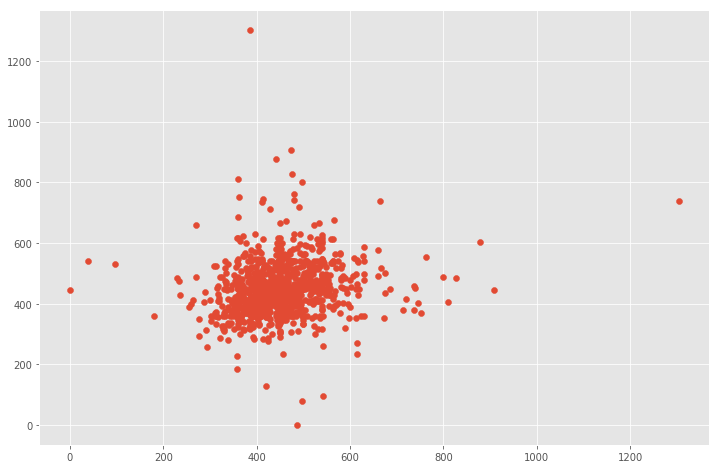

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);